# Project "Advanced Lane Finding"

In [2]:
import alf
import glob
import imp
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
%matplotlib inline

FORCE_CALIBRATION = False
CALIB_DATA_FILE_NAME = "./cam_calib_data.p"

imp.reload(alf)

fileList = glob.glob("./camera_cal/calibration*.jpg")
mtx, dist = alf.getCameraCalibrationMatrix(fileList, CALIB_DATA_FILE_NAME, FORCE_CALIBRATION)


Camera calibration data loaded.


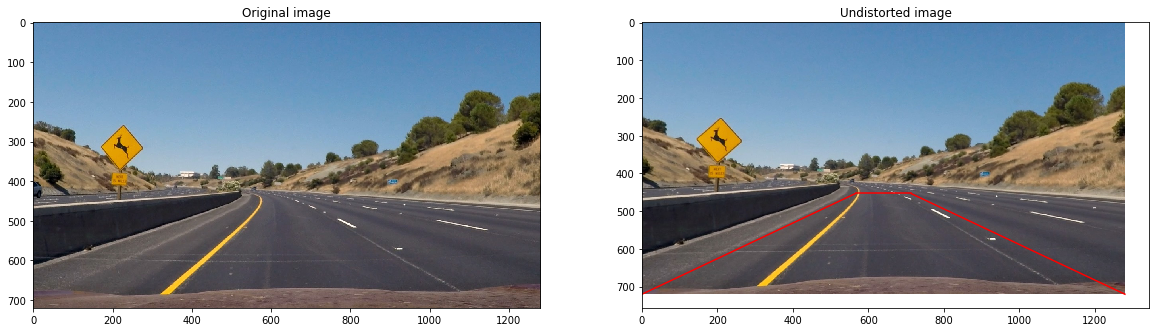

In [6]:
import cv2

IMAGE_FILE = "test_images/test2.jpg"
# Load the image
#img = mpimg.imread("test_images/straight_lines1.jpg")
img = mpimg.imread(IMAGE_FILE)


# Undistort the image
h, w = img.shape[:2]

if False:
    newCamMtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 0, (w,h))
    imgUndist = cv2.undistort(img, mtx, dist, None, newCamMtx)
else:
    imgUndist = cv2.undistort(img, mtx, dist, None, mtx)

if True:
    import os
    try:
        os.mkdir("./undist_images")
    except FileExistsError:
        # Ignore error if folder already exists
        pass
    mpimg.imsave("./undist_images/"+os.path.basename(IMAGE_FILE), imgUndist)
    
H = 2.7
W = 2.26
srcRect = ((0,h), (w,h), (int(w*(1-1/W)), int(h*(1-1/H))), (int(w/W), int(h*(1-1/H))))

if False:
    plt.imshow(imgUndist)
    for i in range(1,len(srcRect)):
        j = (i+1) % len(srcRect)
        plt.plot([srcRect[j][0], srcRect[i][0]], [srcRect[j][1], srcRect[i][1]], 'r-')
else:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title("Original image")
    ax2.imshow(imgUndist)
    ax2.set_title("Undistorted image")
    for i in range(1,len(srcRect)):
        j = (i+1) % len(srcRect)
        ax2.plot([srcRect[j][0], srcRect[i][0]], [srcRect[j][1], srcRect[i][1]], 'r-')



In [ ]:
# Crop the upper part of the image 
newTop = int(h * (1-1/H))
if True:
    imgCrop = imgUndist[newTop:h, :]
else:
    imgCrop = img[newTop:h, :]

print("imgCrop.shape:", imgCrop.shape)
h2 = imgCrop.shape[0]
srcRect2 = ((0,h2), (w,h2), (int(w*(1-1/W)), 0), (w//W, 0))

plt.imshow(imgCrop)
for i in range(1,len(srcRect2)):
    j = (i+1) % len(srcRect2)
    plt.plot([srcRect2[j][0], srcRect2[i][0]], [srcRect2[j][1], srcRect2[i][1]], 'r-')


In [ ]:
# Convert the image to color space HLS
#
#imgHls = cv2.cvtColor(imgCrop, cv2.COLOR_RGB2HLS)#
#
#fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(h2//10,w//10))#
#
#for i,ax in zip(range(3), axs):
#    ax.imshow(imgHls[:,:,i], cmap="gray")

In [ ]:
# Warp the image to (nearly) birds view

dstRect = ((0,h), (w,h), (w, 0), (0, 0))
dstRect2 = ((0,h2), (w,h2), (w, 0), (0, 0))

print("srcRect:", srcRect)
print("dstRect:", dstRect)

print("srcRect2:", srcRect2)
print("dstRect2:", dstRect2)

Mwarp   = cv2.getPerspectiveTransform(np.float32(srcRect2), np.float32(dstRect))
Munwarp = cv2.getPerspectiveTransform(np.float32(dstRect),  np.float32(srcRect2))

imgWarped = cv2.warpPerspective(imgCrop, Mwarp, (w,h), flags=cv2.INTER_LINEAR)
print("imgWarped.shape:", imgWarped.shape)

Mwarp2 = cv2.getPerspectiveTransform(np.float32(srcRect2), np.float32(dstRect2))
imgWarped2 = cv2.warpPerspective(imgCrop, Mwarp2, (w,h2), flags=cv2.INTER_LINEAR)
print("imgCrop.shape:", imgCrop.shape)
print("imgWarped2.shape:", imgWarped2.shape)

#plt.imshow(imgWarped)
#plt.title("imgWarped")



f, sub = plt.subplots(1, 3, figsize=(20,10))
sub[0].imshow(imgWarped)
sub[0].set_title("imgWarped")
sub[1].imshow(imgWarped2)
sub[1].set_title("imgWarped2")
sub[2].imshow(cv2.warpPerspective(imgWarped, Munwarp, (w,h), flags=cv2.INTER_LINEAR))
sub[2].set_title("imgUnwarped")


In [ ]:
# Convert the color space of warped image

imgProc = imgWarped
imgHlsW = cv2.cvtColor(imgProc, cv2.COLOR_RGB2HLS)
#imgLS = np.matmul(imgHlsW[:,:,1], imgHlsW[:,:,2])

imgLS = np.zeros_like(imgHlsW[:,:,2])
Y, X, _ = imgHlsW.shape
for x in range(X):
    for y in range(Y):
        imgLS[y, x] = (float(imgHlsW[y, x, 1]) * float(imgHlsW[y, x, 2]))/256.

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(h2//10,w//10))

axs[0].imshow(imgHlsW[:,:,1], cmap="gray")
axs[0].set_title("L")

axs[1].imshow(imgHlsW[:,:,2], cmap="gray")
axs[1].set_title("S")

axs[2].imshow(imgLS, cmap="gray")
axs[2].set_title("L * S")


In [ ]:
# Apply Sobel operator to saturation plane of bird eyes view 

magThresh = (10, 250)
imgSat = imgHlsW[:,:,2]
#imgSat = imgHlsW[:,:,1]
#imgSat = imgLS

imgSobelAbs = np.abs(cv2.Sobel(imgSat, cv2.CV_64F, 1, 0))
imgSobelScale = np.uint8(255.0*imgSobelAbs/imgSobelAbs.max())
imgSobelBin = np.zeros_like(imgSat) # Remove this line
imgSobelBin[(magThresh[0] < imgSobelScale) & (imgSobelScale < magThresh[1])] = 1


plt.imshow(imgSobelBin, cmap='gray')
plt.title("imgSobelBin")

In [ ]:
NWINDOWS=9

histogram = np.sum(imgSobelBin[imgSobelBin.shape[0]//2:,:], axis=0)
out_img = np.dstack((imgSobelBin, imgSobelBin, imgSobelBin))*255

midpoint = histogram.shape[0]//2
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print("left:", leftx_base, "  right:", rightx_base)

window_height = imgSobelBin.shape[0]//NWINDOWS
nonzero = imgSobelBin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

leftx_current = leftx_base
rightx_current = rightx_base
margin = 100
minpix = 50
left_lane_inds = []
right_lane_inds = []

for window in range(NWINDOWS):
    win_y_bottom = imgSobelBin.shape[0] - (window+1)*window_height
    win_y_top = imgSobelBin.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_bottom),(win_xleft_high,win_y_top),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_bottom),(win_xright_high,win_y_top),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_bottom) & (nonzeroy < win_y_top) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_bottom) & (nonzeroy < win_y_top) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

print("len(leftx) :", len(leftx))
print("len(rightx):", len(rightx))


# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

print("left_fit:", left_fit, "   right_fit:", right_fit)
#plt.plot(histogram)
#plt.title("histogram")
# Generate x and y values for plotting
ploty = np.linspace(0, imgSobelBin.shape[0]-1, imgSobelBin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 255, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')


In [ ]:
ym_per_pixel = 15/imgSobelBin.shape[0]
xm_per_pixel = 3.7/700

y_eval = np.max(ploty)

left_fit_cr = np.polyfit(lefty * ym_per_pixel, leftx * xm_per_pixel, 2)
right_fit_cr = np.polyfit(righty * ym_per_pixel, rightx * xm_per_pixel, 2)

# Calculate curvature
left_curverad  = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pixel + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pixel + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

print("left radius:", left_curverad, "m,  right radius:", right_curverad, "m")

lane_pos_y = imgSobelBin.shape[0]-1
left_lane_pos = left_fit[0]*lane_pos_y**2 + left_fit[1]*lane_pos_y + left_fit[2]
right_lane_pos = right_fit[0]*lane_pos_y**2 + right_fit[1]*lane_pos_y + right_fit[2]

print("lane pos left:", left_lane_pos, "  right:", right_lane_pos)
print("lane pos type(left):", type(left_lane_pos), "  right:", right_lane_pos)


lane_center = (left_lane_pos + right_lane_pos) / 2
dist_from_lane_center = lane_center - imgSobelBin.shape[1]//2

print("dist from lane center:", dist_from_lane_center, " => ", (dist_from_lane_center * xm_per_pixel), "m")

In [ ]:
overlayOffs = imgUndist.shape[0] - imgCrop.shape[0]

imgMarked = np.zeros_like(imgProc)
imgMarked[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
imgMarked[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 255, 255]
for i in range(len(left_fitx)):
    y = int(ploty[i])
#    cv2.circle(imgMarked, (int(left_fitx[i]), y), 5, (255,0,0))
#    cv2.circle(imgMarked, (int(right_fitx[i]), y), 5, (0, 255,255))
    cv2.line(imgMarked, (int(left_fitx[i]), y), (int(right_fitx[i]), y), color=(0, 255,0))

imgUnwarped = np.zeros_like(imgMarked)
imgUnwarped[:,:] = cv2.warpPerspective(imgMarked, Munwarp, (w, h), flags=cv2.INTER_LINEAR)

imgOverlayed = np.copy(imgUndist)

imgUnwarpedShifted = np.zeros_like(imgUnwarped)
imgUnwarpedShifted[overlayOffs:,:] = imgUnwarped[:imgCrop.shape[0],:]
imgOverlayed = cv2.addWeighted(imgUndist, 1, imgUnwarpedShifted, 0.2, 0)
    
fig, sub = plt.subplots(1, 3, figsize=(20,10))
sub[0].imshow(imgMarked)
sub[0].set_title("warped")
sub[1].imshow(imgUnwarped)
sub[1].set_title("unwarped")
sub[2].imshow(imgOverlayed)
sub[2].set_title("overlayed")
